# Building the Hetnet

This file does the initial conversion of SemmedDB into a Hetnet that will be used for future analysis

This has multiples steps:

1. Some minor processing steps
    1. Remove general terms
    2. Combining PMIDs for each unique S-P-O triple and saving
3. Prepare the Nodes file for saving
    4. Ensuring Correct Semanntic Types of the nodes
        1. Resolving Issues with Multiple types for a single CUI
4. Edge File Preparations
    5. Developing Edge Abbreviations for the network
    6. Ensuring that all edges directions follow the same convention
    7. Restoring the PMID information to the Edges
    8. De-duplicating the edges
9. Saving

In [1]:
import os
import pickle
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import sys
sys.path.append('../../hetnet-ml/src')
import graph_tools as gt

sys.path.append('../tools')
import load_umls

In [2]:
sem_df = pd.read_csv('../data/semmedVER31_R_clean_de-depricate.csv')

/opt/mmayers/software/anaconda3/envs/integrate/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print('Rows: {:,}'.format(sem_df.shape[0]))
print('Cols: {}'.format(sem_df.shape[1]))

Rows: 104,814,789
Cols: 12


In [4]:
sem_df.head(2)

,PREDICATION_ID,SENTENCE_ID,PMID,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,SUBJECT_NOVELTY,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY
0,38999,87169,4958141,PART_OF,C0040291,Tissue Extracts,bacs,1,C0085979,Cavia,mamm,1
1,39000,87167,13997680,LOCATION_OF,C0005767,Blood,tisu,1,C0007061,Carboxyhemoglobin,aapp,1


# 1. Processing

## Remove Generic Concepts

Generic concepts ([defined here](https://skr3.nlm.nih.gov/SemMedDB/dbinfo.html)) are too generic for this analysis and should be removed from the data. These concepts have a `SUBJECT_NOVELTY` or `OBJECT_NOVELTY` value of 0.  So we will only keep non-zero values in both columns

In [5]:
sem_df = sem_df.query('SUBJECT_NOVELTY != 0 and OBJECT_NOVELTY != 0')
print('Rows {:,}'.format(sem_df.shape[0]))

Rows 74,560,150


## Count PMIDs

Lets see how many PMIDs there are for each unique S-P-O triple

In [6]:
from collections import defaultdict

DataFrame.grouby is terrible:

    pmids = sem_df.groupby(['SUBJECT_CUI', 'PREDICATE', 'OBJECT_CUI'])['PMID'].apply(set).to_dict()
    
This will take 45+ min... DONT DO THIS!!!

In [7]:
pmids = defaultdict(set)

col_names = sem_df.columns.tolist()

pmid_idx = col_names.index('PMID')
sub_idx = col_names.index('SUBJECT_CUI')
pred_idx = col_names.index('PREDICATE')
obj_idx = col_names.index('OBJECT_CUI')

for tup in tqdm(sem_df.itertuples(False, None), total=len(sem_df)):
    
    pmid = tup[pmid_idx]
    sub = tup[sub_idx]
    pred = tup[pred_idx]
    obj = tup[obj_idx]
    
    pmids[(sub, pred, obj)].add(pmid)

100%|██████████| 74560150/74560150 [08:04<00:00, 154042.62it/s] 


In [8]:
# See the PMIDs Associated with the first line above
row_idx = 0

s = sem_df.loc[row_idx, 'SUBJECT_CUI']
p = sem_df.loc[row_idx, 'PREDICATE']
o = sem_df.loc[row_idx, 'OBJECT_CUI']

pmids[(s, p, o)]

{464373, 4958141, 4960005, 5188517, 14810953, 15777937}

In [9]:
counts = [len(v) for v in pmids.values()]

In [10]:
counts = (pd.Series(counts)
            .value_counts()
            .to_frame()
            .reset_index()
            .rename(columns={'index': 'Num PMIDs', 0: 'SPO Triples'}))

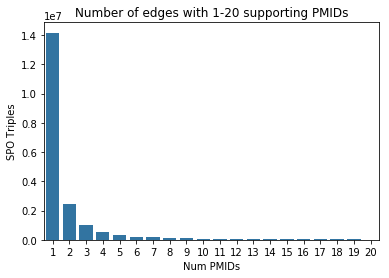

In [11]:
data = counts[counts['Num PMIDs'] < 21]

sns.barplot(x='Num PMIDs', y='SPO Triples', data=data, color = sns.color_palette()[0])
plt.title('Number of edges with 1-20 supporting PMIDs');

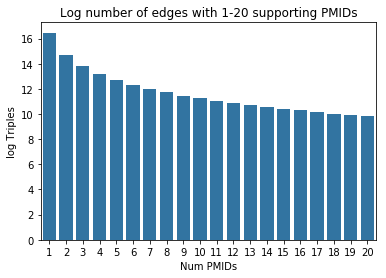

In [12]:
counts['log Triples'] = np.log(counts['SPO Triples'])
data=counts[counts['Num PMIDs'] < 21]

sns.barplot(x='Num PMIDs', y='log Triples', data=data, color=sns.color_palette()[0])
plt.title('Log number of edges with 1-20 supporting PMIDs');

In [13]:
for i in range(1, 11):
    print("Edges with at least {} unique PMIDs: {:,}".format(i, counts[counts['Num PMIDs'] >= i]['SPO Triples'].sum()))

Edges with at least 1 unique PMIDs: 19,812,322
Edges with at least 2 unique PMIDs: 5,654,608
Edges with at least 3 unique PMIDs: 3,187,108
Edges with at least 4 unique PMIDs: 2,204,867
Edges with at least 5 unique PMIDs: 1,680,001
Edges with at least 6 unique PMIDs: 1,353,287
Edges with at least 7 unique PMIDs: 1,130,325
Edges with at least 8 unique PMIDs: 969,417
Edges with at least 9 unique PMIDs: 847,297
Edges with at least 10 unique PMIDs: 751,232


### De-Duplicate

The data will be faster to work with if duplicate items are removed.

In [14]:
sem_df = sem_df.drop_duplicates(subset=['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE', 'PREDICATE',
                                        'OBJECT_CUI', 'OBJECT_NAME', 'OBJECT_SEMTYPE'])

print('Rows Remaining: {:,}'.format(sem_df.shape[0]))

Rows Remaining: 20,258,352


# 2. Prepare Node FIles

## Begin Analysis of Sem-Types

Semtypes are abbreviated, so need to get mappings to true name.  
Examining the length of the map file, there should be 133 semtypes.

In [15]:
len(set(sem_df['SUBJECT_SEMTYPE'].unique()).union(set(sem_df['OBJECT_SEMTYPE'].unique())))

133

### Normalizing semtypes for CUIs with multiple semtypes

We know that there are multiple Semtypes for a given CUI found throghout the database.  Can we just use a voting system? That with the most occruances of a given semtype gets that semtype?

For a CUI thats a Gene e.g. `C1337111` or the `POMC gene` we want something thats a subclass of Genes and Genomes (aka gngm).

In [16]:
sem_df.query('SUBJECT_CUI == "C1337111"')['SUBJECT_SEMTYPE'].value_counts()

aapp    4186
gngm     880
horm     801
phsu     264
nsba      31
lbpr       1
bacs       1
Name: SUBJECT_SEMTYPE, dtype: int64

Unfortunately, aapp is a sublcass of Chemicals & Drugs, so this would be given the wrong superclass if identified.

However, it will be easier to do this if the nodes are sperated from the edges first


#### Semmtypes abbreviation mappings

Files with the mapping information were [downloaded here](https://metamap.nlm.nih.gov/SemanticTypesAndGroups.shtml)

In [17]:
abbv_to_type = dict()
with open('../data/SemanticTypes_2013AA.txt') as fin:
    for line in fin:
        line = line.strip()
        lspt = line.split('|')
        abbv_to_type[lspt[0]] = lspt[-1]
type_to_abbv = {v:k for k, v in abbv_to_type.items()}

Semtypes also have a supertype.   
The mapping file has this structure:

    ANAT|Anatomy|T017|Anatomical Structure

#### Semtype supertypes mappings

In [18]:
abbv_to_super = dict()
with open('../data/SemGroups_2013.txt') as fin:
    for line in fin:
        line = line.strip()
        lspt = line.split('|')
        abbv_to_super[type_to_abbv[lspt[-1]]] = lspt[1]

#### Check to see that all of the semtype abbreviations in the SemmedDB are repepresented in this mapping file

In [19]:
semtype_abbvs = abbv_to_super.keys()
unused_abbvs = set(sem_df.query('SUBJECT_SEMTYPE not in @semtype_abbvs')['SUBJECT_SEMTYPE'].unique())
unused_abbvs.update(set(sem_df.query('OBJECT_SEMTYPE not in @semtype_abbvs')['OBJECT_SEMTYPE'].unique()))

unused_abbvs

{'alga', 'invt', 'rich'}

There are a few that aren't in there, so lets see if we can figure out what they should be

In [20]:
sem_df.query('SUBJECT_SEMTYPE == "alga"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
3276,C0002032,"Algae, Green",alga
5130,C0002028,Algae,alga


In [21]:
sem_df.query('SUBJECT_SEMTYPE == "invt"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
187,C0012518,Dipetalonema perstans,invt
294,C0026584,Culicidae,invt


In [22]:
sem_df.query('SUBJECT_SEMTYPE == "rich"').head(2)[['SUBJECT_CUI', 'SUBJECT_NAME', 'SUBJECT_SEMTYPE']]

,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE
1499,C0035587,Rickettsia prowazekii,rich
7037,C0010240,Coxiella burnetii,rich


In [23]:
# Looked ups a few cuis with these and they are all of the living beings type, 
# so we will set these to that semtype
abbv_to_super['invt'] = 'Living Beings'
abbv_to_super['alga'] = 'Living Beings'
abbv_to_super['rich'] = 'Living Beings'

## Get the nodes ready to be put into a CSV

We will use the Neo4j import format, with the column headers ID (unique ID), name (string name), and Label (node type).

In [24]:
# Get the nodes ready to be in a CSV
# We will use the N

snodes = pd.DataFrame()
onodes = pd.DataFrame()


snodes['ID'] = sem_df['SUBJECT_CUI']
snodes['name'] = sem_df['SUBJECT_NAME']
snodes['label'] = sem_df['SUBJECT_SEMTYPE'].apply(lambda x: abbv_to_super.get(x))

onodes['ID'] = sem_df['OBJECT_CUI']
onodes['name'] = sem_df['OBJECT_NAME']
onodes['label'] = sem_df['OBJECT_SEMTYPE'].apply(lambda x: abbv_to_super.get(x))


nodes = pd.concat([snodes, onodes])
nodes.drop_duplicates(inplace=True)
nodes = nodes.reset_index(drop=True)

nodes.head()

,ID,name,LABEL
0,C0040291,Tissue Extracts,Chemicals & Drugs
1,C0005767,Blood,Anatomy
2,C0702166,Acne,Disorders
3,C0027809,Neurilemmoma,Disorders
4,C1010578,Spermophilus tridecemlineatus,Living Beings


In [25]:
print('There are {} entries and {} unique IDs'.format(nodes.shape[0], nodes['ID'].nunique()))
0
num_duped = nodes[nodes.duplicated(subset='ID', keep=False)].drop_duplicates().shape[0]
print('{} IDs have been found to have multiple semantic types'.format(num_duped))

There are 293772 entries and 257243 unique IDs
71595 IDs have been found to have multiple semantic types


See if there are any untyped nodes

In [26]:
no_semtype = nodes.isnull().sum(axis=1).astype(bool)
nodes[no_semtype]

,ID,name,LABEL


## Fix semmantic types using the UMLS Metathesaurus

Let's not guess and go directly to the source to make sure the types are correct

#### First need a map from CUI to T-code for semmantics

In [27]:
mrsty = load_umls.open_mrsty()

cui_to_t_code = defaultdict(list)

col_names = mrsty.columns.tolist()
cui_idx = col_names.index('CUI')
t_idx = col_names.index('TUI')

for line in tqdm(mrsty.itertuples(index=False, name=None), total=len(mrsty)):
    
    cui_to_t_code[line[cui_idx]].append(line[t_idx])

100%|██████████| 3962617/3962617 [00:06<00:00, 635034.65it/s]


In [28]:
for i, (k, v) in enumerate(cui_to_t_code.items()):
    print(k, v)
    if i==10:
        break

C4127496 ['T204']
C0407156 ['T061']
C1444390 ['T058']
C0278707 ['T061']
C3002410 ['T002']
C3493400 ['T116', 'T123']
C4386023 ['T013']
C1471413 ['T007']
C2676830 ['T028']
C3934002 ['T004']
C2141718 ['T033']


Some have multiple codes, but if they have the same Super-Semtype, not an issue

#### Get a map from T-code to super semmantic type

In [29]:
# ANAT|Anatomy|T017|Anatomical Structure

t_code_to_super = dict()
with open('../data/SemGroups_2013.txt') as fin:
    for line in fin:
        line = line.strip()
        ls = line.split('|')
        t_code_to_super[ls[2]] = ls[1]

#### Get a map from CUI to super semmantic type

In [30]:
cui_to_t_code['C0026341']

['T075', 'T170']

In [31]:
t_code_to_super['T075']

'Devices'

In [32]:
t_code_to_super['T170']

'Concepts & Ideas'

In [33]:
cui_to_t_code['C0086711']

['T109', 'T121', 'T131']

In [34]:
t_code_to_super['T109'], t_code_to_super['T131'], t_code_to_super['T121']

('Chemicals & Drugs', 'Chemicals & Drugs', 'Chemicals & Drugs')

In [35]:
cui_to_super = dict()
issues = dict()

for k, v in cui_to_t_code.items():
    # Only 1 T-Code, so map to its super semmantic type
    if len(v) == 1:
        cui_to_super[k] = t_code_to_super[v[0]]
    else:
        # Most multiple T-Codes should have the same supertype
        v_set = set([t_code_to_super[x] for x in v])
        if len(v_set) == 1:
            cui_to_super[k] = v_set.pop()
        # If they don't have the same supertype, return as a list...
        else:
            # If nothing prints they we have true 1-1 mapping and noting to worry about
            issues[k] = v_set
            
if issues:
    print('There are {} CUIs with multiple Supertypes...'.format(len(issues)))

There are 1586 CUIs with multiple Supertypes...


## Fix Multiple Semtypes

There are some CUIs that map to multiple Super-Semtypes.... Unfortunaltely these will have to be treated as judgement calls and fixed by hand.

In [36]:
# See what kind of semtypes pair together... Can we make some kind of choice to overcome conflict?
multi_sems = sorted(list(set([' | '.join(sorted(list(v))) for v in issues.values()])))
multi_sems

['Activities & Behaviors | Concepts & Ideas',
 'Activities & Behaviors | Procedures',
 'Anatomy | Chemicals & Drugs',
 'Chemicals & Drugs | Devices',
 'Chemicals & Drugs | Genes & Molecular Sequences',
 'Chemicals & Drugs | Objects',
 'Chemicals & Drugs | Phenomena',
 'Concepts & Ideas | Devices',
 'Concepts & Ideas | Objects',
 'Concepts & Ideas | Procedures',
 'Objects | Organizations']

In [37]:
def examine_problem_cuis(combined):
    type_1, type_2 = combined.split(' | ')
    
    problems = []

    for k, v in issues.items():
        if type_1 in v and type_2 in v:
            problems.append(k)
        
    return nodes.query('ID in @problems')[['ID', 'name']].drop_duplicates()

Since the semmantic map was originally from umls, some of the CUIs may not be in the nodes.  So not all will need to be examined and fixed.

In [38]:
for m in multi_sems:
    print('{}: {}'.format(m, len(examine_problem_cuis(m))))

Activities & Behaviors | Concepts & Ideas: 10
Activities & Behaviors | Procedures: 2
Anatomy | Chemicals & Drugs: 3
Chemicals & Drugs | Devices: 0
Chemicals & Drugs | Genes & Molecular Sequences: 4
Chemicals & Drugs | Objects: 47
Chemicals & Drugs | Phenomena: 4
Concepts & Ideas | Devices: 1
Concepts & Ideas | Objects: 59
Concepts & Ideas | Procedures: 73
Objects | Organizations: 224


Start with some of the smaller ones first, see if there's an obvious answer to resolve...

In [39]:
idx = 1

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx])

Activities & Behaviors | Procedures


,ID,name
79024,C0009597,Computer-Assisted Instruction
117938,C1510551,Intelligent Tutoring Systems


Not missiion critical, but I think Procedures fits better here...

In [40]:
# Make a function to fix the mapings for these IDs
def set_semtype(problems, new_sem):
    res = examine_problem_cuis(problems).copy()
    res['type'] = new_sem
    return res.set_index('ID')['type'].to_dict()

In [41]:
fixed_sems = {}

fixed_sems.update(set_semtype(multi_sems[idx], 'Procedures'))
fixed_sems

{'C0009597': 'Procedures', 'C1510551': 'Procedures'}

In [42]:
idx = 2

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx])

Anatomy | Chemicals & Drugs


,ID,name
131983,C0879593,autologous dendritic cells
162198,C1328049,LMP2A-specific cytotoxic T-lymphocytes
175554,C1516687,Coactivated T Cell


These seem more like a Anatomy (cell-type) than a Chemical, so we'll go with that

In [43]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Anatomy'))
fixed_sems

{'C0009597': 'Procedures',
 'C0879593': 'Anatomy',
 'C1328049': 'Anatomy',
 'C1510551': 'Procedures',
 'C1516687': 'Anatomy'}

In [44]:
idx = 4

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx])

Chemicals & Drugs | Genes & Molecular Sequences


,ID,name
58271,C0017272,Gene Library
63289,C0751608,cDNA Library
63388,C0017430,Genomic Library
71149,C0872147,DNA Library


These seem like pretty generic concepts... could go either way, but we'll set them to Genes & Molecular Sequences

In [45]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Genes & Molecular Sequences'))
fixed_sems

{'C0009597': 'Procedures',
 'C0017272': 'Genes & Molecular Sequences',
 'C0017430': 'Genes & Molecular Sequences',
 'C0751608': 'Genes & Molecular Sequences',
 'C0872147': 'Genes & Molecular Sequences',
 'C0879593': 'Anatomy',
 'C1328049': 'Anatomy',
 'C1510551': 'Procedures',
 'C1516687': 'Anatomy'}

In [46]:
idx = 6

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx])

Chemicals & Drugs | Phenomena


,ID,name
36548,C0034549,Radioactive Fallout
53522,C0021265,Industrial Waste
55037,C0034552,Radioactive Waste
84024,C0001111,Acid Rain


Again, these seem like pretty generic concepts... we'll set them to Phenomena

In [47]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Phenomena'))
fixed_sems

{'C0001111': 'Phenomena',
 'C0009597': 'Procedures',
 'C0017272': 'Genes & Molecular Sequences',
 'C0017430': 'Genes & Molecular Sequences',
 'C0021265': 'Phenomena',
 'C0034549': 'Phenomena',
 'C0034552': 'Phenomena',
 'C0751608': 'Genes & Molecular Sequences',
 'C0872147': 'Genes & Molecular Sequences',
 'C0879593': 'Anatomy',
 'C1328049': 'Anatomy',
 'C1510551': 'Procedures',
 'C1516687': 'Anatomy'}

In [48]:
idx = 7

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx])

Concepts & Ideas | Devices


,ID,name
111871,C0026341,"Models, Chemical"


More of a concept...

In [49]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Concepts & Ideas'))
fixed_sems

{'C0001111': 'Phenomena',
 'C0009597': 'Procedures',
 'C0017272': 'Genes & Molecular Sequences',
 'C0017430': 'Genes & Molecular Sequences',
 'C0021265': 'Phenomena',
 'C0026341': 'Concepts & Ideas',
 'C0034549': 'Phenomena',
 'C0034552': 'Phenomena',
 'C0751608': 'Genes & Molecular Sequences',
 'C0872147': 'Genes & Molecular Sequences',
 'C0879593': 'Anatomy',
 'C1328049': 'Anatomy',
 'C1510551': 'Procedures',
 'C1516687': 'Anatomy'}

In [50]:
idx = 0

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx])

Activities & Behaviors | Concepts & Ideas


,ID,name
86135,C0032675,Population Policy
125082,C0037429,Social Policy
137835,C0680807,war on drugs
214822,C0011752,Development Policy
225803,C0683733,foreign policy
240323,C0683732,energy policy
262492,C0026099,Migration Policy
265896,C0871863,Professional Examinations
271802,C0007835,Certificate of Need
273941,C0871802,Licensure Examinations


These also seem to be more of Concepts than Activities and Behaviors... 

In [51]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Concepts & Ideas'))
fixed_sems

{'C0001111': 'Phenomena',
 'C0007835': 'Concepts & Ideas',
 'C0009597': 'Procedures',
 'C0011752': 'Concepts & Ideas',
 'C0017272': 'Genes & Molecular Sequences',
 'C0017430': 'Genes & Molecular Sequences',
 'C0021265': 'Phenomena',
 'C0026099': 'Concepts & Ideas',
 'C0026341': 'Concepts & Ideas',
 'C0032675': 'Concepts & Ideas',
 'C0034549': 'Phenomena',
 'C0034552': 'Phenomena',
 'C0037429': 'Concepts & Ideas',
 'C0680807': 'Concepts & Ideas',
 'C0683732': 'Concepts & Ideas',
 'C0683733': 'Concepts & Ideas',
 'C0751608': 'Genes & Molecular Sequences',
 'C0871802': 'Concepts & Ideas',
 'C0871863': 'Concepts & Ideas',
 'C0872147': 'Genes & Molecular Sequences',
 'C0879593': 'Anatomy',
 'C1328049': 'Anatomy',
 'C1510551': 'Procedures',
 'C1516687': 'Anatomy'}

The shorter ones are done... now we'll look at the longer ones by taking a random sample of ~20 from each

In [52]:
idx = 5

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx]).sample(20)

Chemicals & Drugs | Objects


,ID,name
18623,C0042438,Vegetable Oils
290987,C1445804,Pumpkin seed oil extract
59881,C1509841,HYDROGENATED SOYBEAN OIL
121960,C0054634,caramel
119725,C0458160,Grapeseed oil
20795,C0075639,sunflower seed oil
48405,C0376597,Dietary Sucrose
19792,C0244994,Wheat germ oil
12313,C0072982,rapeseed oil
73019,C0682953,saturated dietary fat


All seem to be some kind of dietary component... Since they're not super-specific chemical compounds, we'll keep them with the type 'Objects'

In [53]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Objects'))

In [54]:
idx = 8

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx]).sample(20)

Concepts & Ideas | Objects


,ID,name
58157,C0262846,"Information Systems, Data Management, Cardiology"
154969,C0079815,"Medical Records Systems, Computerized"
213384,C0024763,Manuals
132989,C0079150,"Medical Records, Computerized"
108228,C0870393,Decision Support Systems
22631,C0005358,Bibliography
116442,C0037585,Computer software
210028,C0018700,Health Diaries
269663,C0868951,Drug distribution systems
260093,C0180070,Computer Interfaces


Not super important, neither of theses Sem-types are too biologically revelant.  We'll set them to 'Objects'

In [55]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Objects'))

In [56]:
idx = 9

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx]).sample(20)

Concepts & Ideas | Procedures


,ID,name
53138,C0871272,Rokeach Dogmatism Scale
4853,C0683454,Internal-External Locus of Control Scale
60114,C0683457,State-trait anger expression inventory
30204,C0871459,Subtests
80049,C0870266,Child Behavior Checklist
146673,C0870241,California F Scale
107950,C0870965,Nonlinear Regression
70387,C0679587,Franck Drawing Completion Test
69947,C0036150,Sampling Studies
74467,C0542548,Personal Orientation Inventory


Again, either choice is not super critical, will make them Concepts & Ideas

In [57]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Concepts & Ideas'))

In [58]:
idx = 10

print(multi_sems[idx])
examine_problem_cuis(multi_sems[idx]).sample(20)

Objects | Organizations


,ID,name
239352,C0562708,Pharmacy - shop
15678,C0011344,Dental Clinics
50400,C0587449,Respiratory intensive care unit
1221,C0020003,"Hospitals, Community"
172015,C0596183,biomedical facility
90208,C0587445,Adult intensive care unit
45962,C0598858,mental health center
23040,C0557799,Grammar school
235174,C0557633,Rehabilitation hostel
83305,C0337966,Hospital ship


Seem more like organiziations.

In [59]:
fixed_sems.update(set_semtype(multi_sems[idx], 'Organizations'))

In [60]:
cui_to_super.update(fixed_sems)

## Re-label the semmantic types to their true type

In [63]:
before_len = len(nodes)
nodes['label'] = nodes['ID'].apply(lambda x: cui_to_super[x])
nodes = nodes[['ID', 'name', 'label']].drop_duplicates().reset_index(drop=True)

print("Went from {} rows in nodes to {} with {} unique CUIS".format(before_len, len(nodes), nodes['ID'].nunique()))

Went from 293772 rows in nodes to 257243 with 257243 unique CUIS


Looks like we finally have a 1:1 relationship of unique IDs to rows in our nodes table

# 3. Edges File

## Prediacate types

[Semmed Docs](https://skr3.nlm.nih.gov/SemMed/jsp/SemMedDocumentation2.pdf)


The docs above show only 26 predicates, lets see how many the data actually contains an and what they are...

In [64]:
print(sem_df['PREDICATE'].nunique())

59


Looks like 59 total predicates.  There are negated predicats, but still, negating all 26 should only yield 52 total.  There are also some that are all lower-case, which do not seem to be found in the documents.

In [65]:
sem_df['PREDICATE'].unique()

array(['PART_OF', 'LOCATION_OF', 'PROCESS_OF', 'ISA', 'COEXISTS_WITH',
       'INTERACTS_WITH', 'TREATS', 'USES', 'METHOD_OF', 'CAUSES',
       'ASSOCIATED_WITH', 'AFFECTS', 'DIAGNOSES', 'PRECEDES',
       'NEG_INHIBITS', 'compared_with', 'ADMINISTERED_TO', 'STIMULATES',
       'DISRUPTS', 'higher_than', 'AUGMENTS', 'OCCURS_IN', 'INHIBITS',
       'COMPLICATES', 'PREVENTS', 'NEG_AFFECTS', 'PREDISPOSES',
       'different_from', 'MANIFESTATION_OF', 'same_as', 'NEG_higher_than',
       'PRODUCES', 'NEG_DISRUPTS', 'NEG_CAUSES', 'NEG_INTERACTS_WITH',
       'NEG_PROCESS_OF', 'NEG_COEXISTS_WITH', 'NEG_PART_OF', 'NEG_USES',
       'lower_than', 'NEG_METHOD_OF', 'NEG_PREVENTS', 'CONVERTS_TO',
       'NEG_AUGMENTS', 'NEG_LOCATION_OF', 'NEG_DIAGNOSES',
       'NEG_PREDISPOSES', 'NEG_TREATS', 'NEG_PRODUCES',
       'NEG_ASSOCIATED_WITH', 'NEG_COMPLICATES', 'NEG_STIMULATES',
       'NEG_OCCURS_IN', 'NEG_ADMINISTERED_TO', 'NEG_CONVERTS_TO',
       'NEG_lower_than', 'NEG_PRECEDES', 'NEG_MANIFESTATI

## Edge Semmantics Abbreviations

According to hetionet conventions, edges must be written as `EDGETYPE_abbrev` where the abbreviation is START_NODE Abv, Predicate Abv, END_NODE Abv.  for example a Compound that treats a Disease is abbreviated TREATS_CtD.  

We must come up with unique abbreviations for each semantic type for the nodes as well as each predicate. These concatinated together will give a unique abbreviation for each edge type.

In [66]:
p_abv = {
 'ADMINISTERED_TO': 'at',
 'AFFECTS': 'af',
 'ASSOCIATED_WITH': 'aw',
 'AUGMENTS': 'ag',
 'CAUSES': 'c',
 'COEXISTS_WITH': 'cw',
 'COMPLICATES': 'cp',
 'CONVERTS_TO': 'ct',
 'DIAGNOSES': 'dg',
 'DISRUPTS': 'ds',
 'INHIBITS': 'in',
 'INTERACTS_WITH': 'iw',
 'ISA': 'i',
 'LOCATION_OF': 'lo',
 'MANIFESTATION_OF': 'mfo',
 'METHOD_OF': 'mo',
 'NEG_ADMINISTERED_TO': 'nat',
 'NEG_AFFECTS': 'naf',
 'NEG_ASSOCIATED_WITH': 'naw',
 'NEG_AUGMENTS': 'nag',
 'NEG_CAUSES': 'nc',
 'NEG_COEXISTS_WITH': 'ncw',
 'NEG_COMPLICATES': 'ncp',
 'NEG_CONVERTS_TO': 'nct',
 'NEG_DIAGNOSES': 'ndg',
 'NEG_DISRUPTS': 'nds',
 'NEG_INHIBITS': 'nin',
 'NEG_INTERACTS_WITH': 'niw',
 'NEG_LOCATION_OF': 'nlo',
 'NEG_MANIFESTATION_OF': 'nmfo',
 'NEG_METHOD_OF': 'nmo',
 'NEG_OCCURS_IN': 'noi',
 'NEG_PART_OF': 'npo',
 'NEG_PRECEDES': 'npc',
 'NEG_PREDISPOSES': 'nps',
 'NEG_PREVENTS': 'npv',
 'NEG_PROCESS_OF': 'npro',
 'NEG_PRODUCES': 'npd',
 'NEG_STIMULATES': 'nst',
 'NEG_TREATS': 'nt',
 'NEG_USES': 'nu',
 'NEG_higher_than': 'nht',
 'NEG_lower_than': 'nlt',
 'OCCURS_IN': 'oi',
 'PART_OF': 'po',
 'PRECEDES': 'pc',
 'PREDISPOSES': 'ps',
 'PREP': 'pr',
 'PREVENTS': 'pv',
 'PROCESS_OF': 'pro',
 'PRODUCES': 'pd',
 'STIMULATES': 'st',
 'TREATS': 't',
 'USES': 'u',
 'compared_with': 'cpw',
 'different_from': 'df',
 'different_than': 'dt',
 'higher_than': 'ht',
 'lower_than': 'lt',
 'same_as': 'sa'}

In [67]:
# get abbreviations for semtypes
super_sems = set(abbv_to_super.values())

len(super_sems)
super_sems

{'Activities & Behaviors',
 'Anatomy',
 'Chemicals & Drugs',
 'Concepts & Ideas',
 'Devices',
 'Disorders',
 'Genes & Molecular Sequences',
 'Geographic Areas',
 'Living Beings',
 'Objects',
 'Occupations',
 'Organizations',
 'Phenomena',
 'Physiology',
 'Procedures'}

## Node Type Abbreviations

Nodes must also have an abbreviation

In [68]:
# Run these by hand as there are few, and some don't lend themselves well to auto-generation
sem_abv = {
 'Activities & Behaviors': 'AB',
 'Anatomy': 'A',
 'Compound': 'C',
 'Chemicals & Drugs': 'CD',
 'Concepts & Ideas': 'CI',
 'Devices': 'DV',
 'Disease': 'D',
 'Disorders': 'DO',
 'Genes & Molecular Sequences': 'G',
 'Geographic Areas': 'GA',
 'Living Beings': 'LB',
 'Objects': 'OB',
 'Occupations': 'OC',
 'Organizations': 'OR',
 'Phenomena': 'PH',
 'Physiology': 'PS',
 'Procedures': 'PR'
}

# Edge Directions

Most edges may be bi-directions, but some are definitely better exprested as uni-directional.  Here we will classify predicates as bi- or uni-dierectional based on the semantic meaning of the predicate.  Bidirectionl edges have an empty string, whereas uni-directional have a direction marker `'>'`. For example an undirected edge, such as a compound that treats a disease, is written as `TREATS_CtD`. However, a directed edge, like Compound1 converts to Compound 2 would be written as `CONVERTS_TO_Cct>C`.

Edge directions were chosen based on the description found in [this documnetation](https://skr3.nlm.nih.gov/SemMed/jsp/SemMedDocumentation2.pdf).

In [69]:
edge_dir = {
 'ADMINISTERED_TO': '',
 'AFFECTS': '',
 'ASSOCIATED_WITH': '',
 'AUGMENTS': '',
 'CAUSES': '',
 'COEXISTS_WITH': '',
 'COMPLICATES': '',
 'CONVERTS_TO': '>',
 'DIAGNOSES': '',
 'DISRUPTS': '',
 'INHIBITS': '',
 'INTERACTS_WITH': '',
 'ISA': '>',
 'LOCATION_OF': '',
 'MANIFESTATION_OF': '>',
 'METHOD_OF': '',
 'NOM': '',
 'OCCURS_IN': '',
 'PART_OF': '>',
 'PRECEDES': '>',
 'PREDISPOSES': '',
 'PREP': '',
 'PREVENTS': '',
 'PROCESS_OF': '>',
 'PRODUCES': '>',
 'SPEC': '',
 'STIMULATES': '',
 'TREATS': '',
 'USES': '',
 'compared_with': '',
 'different_from': '',
 'different_than': '',
 'higher_from': '',
 'higher_than': '',
 'lower_than': '',
 'same_as': '',
 'than_as': ''}

In [70]:
# Make a mapper from SEMTYPE to sem abbrev
kind_map = {}

for k, v in abbv_to_super.items():
    kind_map[k] = sem_abv[v]

In [71]:
id_to_type = nodes.set_index('ID')['label'].to_dict()
id_to_type_abbv = {k: sem_abv.get(v) for k, v in id_to_type.items()}

In [72]:
edges = pd.DataFrame()

edges['start_id'] = sem_df['SUBJECT_CUI']
edges['end_id'] = sem_df['OBJECT_CUI']
edges['type'] = sem_df['PREDICATE']

In [73]:
print(len(edges))
# Make sure that there aren't any corrupted predicates...
edges = edges.query('type in @p_abv.keys()')
print(len(edges))

20258352
20258352


## Putting together Edge Abbreviations

Most edges are going to be treated as bi-directional, so order doesn't really matter too much, but when connecting 2 different metanodes, all `start_id`s must be of the same metanode type and all `end_id`s must be of the other. 

For example, all edges of TREATS between Compound and Disease should have a start_id nodetype of Compound and end_id type of Disease.... SemmedDB doesn't really care about this ordering, so we will ensure that all have a consistent order in this network file.


1. First figure out which edges need Start and End swapped
2. Then add in the pmids supporting each edge
3. Finally, do the swap of IDs


In [74]:
edges['abbrev'] = (edges['start_id'].apply(lambda x: id_to_type_abbv.get(x,x)) 
                    + edges['type'].apply(lambda x: p_abv.get(x,x))
                    + edges['type'].apply(lambda x: edge_dir.get(x,''))
                    + edges['end_id'].apply(lambda x: id_to_type_abbv.get(x,x)))

edges['rev_abbrev'] = (edges['end_id'].apply(lambda x: id_to_type_abbv.get(x,x)) 
                    + edges['type'].apply(lambda x: edge_dir.get(x,''))
                    + edges['type'].apply(lambda x: p_abv.get(x,x))
                    + edges['start_id'].apply(lambda x: id_to_type_abbv.get(x,x)))

In [75]:
print(len(edges))
edges = edges.drop_duplicates()
print(len(edges))
edges.head()

20258352
19812322


,START_ID,END_ID,TYPE,abbrev,rev_abbrev
0,C0040291,C0085979,PART_OF,CDpo>LB,LB>poCD
1,C0005767,C0007061,LOCATION_OF,AloCD,CDloA
2,C0702166,C0043210,PROCESS_OF,DOpro>LB,LB>proDO
3,C0027809,C0038351,PART_OF,DOpo>A,A>poDO
6,C1010578,C0037877,ISA,LBi>LB,LB>iLB


This will just use whatever order is encountered first when going down the rows of the Edges DataFrame

In [76]:
def validate_abbrevs(e_type, abbrev, rev_abbrev):
    if rev_abbrev not in abbreviations:
        abbreviations.update([abbrev])
        return str(e_type) + '_' + str(abbrev)
    else:
        return str(e_type) + '_' + str(rev_abbrev)

In [77]:
%%time
abbreviations = set()
new_types = []
for row in tqdm(edges.itertuples(), total=len(edges)):
    new_types.append(validate_abbrevs(row[3], row[4], row[5]))

100%|██████████| 19812322/19812322 [01:01<00:00, 322385.39it/s]

CPU times: user 1min 1s, sys: 3.42 s, total: 1min 4s
Wall time: 1min 4s


In [78]:
edges = edges.reset_index(drop=True)
edges.head(2)

,START_ID,END_ID,TYPE,abbrev,rev_abbrev
0,C0040291,C0085979,PART_OF,CDpo>LB,LB>poCD
1,C0005767,C0007061,LOCATION_OF,AloCD,CDloA


## Add in the PMID counts as extra data for each edge

In [79]:
len(pmids)

19812322

In [80]:
print(len(edges))

19812322


In [81]:
%%time
edges['pmids'] = pd.Series([pmids[i] for i in tqdm(edges.set_index(['start_id', 'type', 'end_id']).index.tolist())])

100%|██████████| 19812322/19812322 [00:18<00:00, 1059647.82it/s]


CPU times: user 1min 14s, sys: 9.23 s, total: 1min 24s
Wall time: 1min 23s


In [82]:
edges.head(2)

,START_ID,END_ID,TYPE,abbrev,rev_abbrev,pmids
0,C0040291,C0085979,PART_OF,CDpo>LB,LB>poCD,"{4960005, 5188517, 14810953, 15777937, 464373,..."
1,C0005767,C0007061,LOCATION_OF,AloCD,CDloA,"{2901508, 3799562, 26757130, 6744590, 3117072,..."


### Swap start and end IDs for edges where start and end types were swapped...

In [83]:
e_types_current = edges['type'] + '_' + edges['abbrev']

In [84]:
need_swap = e_types_current != pd.Series(new_types)

In [85]:
tmp = edges.loc[need_swap, 'start_id']
edges.loc[need_swap, 'start_id'] = edges.loc[need_swap, 'end_id']
edges.loc[need_swap, 'end_id'] = tmp
edges['type'] = new_types

In [86]:
# drop extra columns
edges = edges[['start_id', 'end_id', 'type', 'pmids']]

In [87]:
edges['type'].nunique()

2900

#### De Duplication

Some edges are now duplicated, so must de-duplicate and combine pmid sets.

In [88]:
%%time
# This part is unfortunately very slow... Cant' really find any good way to speed it up.
grpd = edges.groupby(['start_id', 'end_id', 'type'])
edges = grpd['pmids'].apply(lambda Series: set.union(*Series.values)).reset_index()

CPU times: user 34min 56s, sys: 1min 25s, total: 36min 21s
Wall time: 36min 22s


In [89]:
# Get the number of pmids
edges['n_pmids'] = edges['pmids'].apply(len)

In [90]:
nodes = nodes.dropna()

In [91]:
print('{:,}'.format(len(nodes)))
print('{:,}'.format(len(edges)))

257,243
19,555,814


### Ensure that all ids in the edges appear in the nodes

Also make sure that the nodes don't contain any extra IDs not used by the edges

In [92]:
edge_ids = set(edges['start_id']).union(set(edges['end_id']))
len(edge_ids)

257243

In [93]:
node_ids = set(nodes['ID'])
len(node_ids)

257243

In [94]:
# ensure there are no edge IDs that are not also in thenodes
len(edge_ids - node_ids)

0

In [95]:
# remove nodes that don't appear in the edges
edge_ids = list(edge_ids)
nodes = nodes.query('ID in @edge_ids')

In [96]:
nodes['ID'].nunique()

257243

# 4. Save files to disk

In [ ]:
# Sort values before writing to disk
nodes = nodes.sort_values('label')
edges = edges.sort_values('type')

# Add in colons required by neo4j
nodes = gt.add_colons(nodes)
edges = gt.add_colons(edges)

nodes.to_csv('../data/nodes_VER31_R.csv', index=False)
edges.to_csv('../data/edges_VER31_R.csv', index=False)